## Scarpping Reddit data

In [1]:
pip install praw


     -------------------------------------- 189.3/189.3 kB 3.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [43]:
import os
import praw
from prawcore.exceptions import NotFound
import pandas as pd
from tqdm import tqdm

arr=[]
reddit = praw.Reddit(
    client_id='eLHIfVLEUxnTQlLlGt29_Q',
    client_secret='xalSQxSsLr5oxApVsrobL5dyasmCOw',
    user_agent='python:my_reddit_sentiment_app:v1.0.0 (by u/on_a_no_buy)'
)

try:
    subreddit = reddit.subreddit('sneakers')
    for post in tqdm(subreddit.hot(limit=1000)):
        #print(post.title)
        #print(post.selftext)
        if len(post.comments) > 0:
            comment=post.comments[0].body
        else:
            comment=" "
        arr.append([post.title,post.selftext,post.upvote_ratio,post.created_utc,post.score,comment])
except NotFound:
    print("The requested resource was not found. Please check the subreddit name or resource ID.")
df_sneakers = pd.DataFrame(arr, columns=['Title', 'Body','Upvote_ratio','Timestamp','Upvote_num','comments'])


951it [04:41,  3.38it/s]


In [45]:
#Store the subreddit as csv
df_sneakers.to_csv('sneakers.csv', index=False)


In [48]:
#Merge all the datasets together
# Path to the folder containing the CSV files
folder_path = 'Dataframe_new'

# List to store the DataFrames
dataframes = []

# Iterate over all files in the folder
for file_name in os.listdir(folder_path):
    # Check if the file is a CSV
    if file_name.endswith('.csv'):
        file_path = os.path.join(folder_path, file_name)
        # Read the CSV into a DataFrame
        df = pd.read_csv(file_path)
        df['topic'] = os.path.splitext(file_name)[0]
        dataframes.append(df)
        print(f"Loaded: {file_name}")

print(f"Total CSV files read: {len(dataframes)}")

Loaded: adidas.csv
Loaded: asics.csv
Loaded: fabletics.csv
Loaded: gymshark.csv
Loaded: hoka.csv
Loaded: lululemon.csv
Loaded: newbalance.csv
Loaded: nike.csv
Loaded: puma.csv
Loaded: reebok.csv
Loaded: sneakers.csv
Loaded: underarmour.csv
Total CSV files read: 12


In [49]:
combined_df = pd.concat(dataframes, ignore_index=True)


In [51]:
#save the combined scrapped data into a csv file
combined_df.to_csv('athletic_apparel.csv', index=False)


## Preprocessing data

In [2]:
import pandas as pd
df=pd.read_csv('athletic_apparel.csv')

/Users/navneetparab/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/navneetparab/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [3]:
nan_per_column = df.isnull().sum()
nan_per_column

Title              0
Body            2834
Upvote_ratio       0
Timestamp          0
Upvote_num         0
comments           0
topic              0
dtype: int64

In [4]:
#lowercasing and removing speacial characters
df['clean_Title'] = df['Title'].str.lower().str.replace(r'[^\w\s]', '', regex=True).str.strip()
df['clean_Body'] = df['Body'].str.lower().str.replace(r'[^\w\s]', '', regex=True).str.strip()
df['clean_comments'] = df['comments'].str.lower().str.replace(r'[^\w\s]', '', regex=True).str.strip()


In [5]:
#removing numbers
df['clean_Title']=df['clean_Title'].str.replace(r'\d+','',regex=True)
df['clean_Body']=df['clean_Body'].str.replace(r'\d+','',regex=True)
df['clean_comments']=df['clean_comments'].str.replace(r'\d+','',regex=True)

In [6]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
#removing stopwords
stop_words = set(stopwords.words('english'))  # Load English stopwords
def remove_stopwords(text):
    if isinstance(text, str):  # Ensure text is a string
        return " ".join([word for word in text.split() if word.lower() not in stop_words])
    return ""  # Return empty string if value is NaN or not a string


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/navneetparab/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
#remove stopwords
df['clean_Title'] = df['clean_Title'].apply(remove_stopwords)
df['clean_Body'] = df['clean_Body'].apply(remove_stopwords)
df['clean_comments'] = df['clean_comments'].apply(remove_stopwords)


In [8]:
#lemmatization
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
# Function to lemmatize text
def lemmatize_nltk(text):
    if isinstance(text, str):  # Ensure input is a string
        return " ".join([lemmatizer.lemmatize(word) for word in text.split()])
    return ""


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/navneetparab/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [9]:
df['clean_Title'] = df['clean_Title'].apply(lemmatize_nltk)
df['clean_Body'] = df['clean_Body'].apply(lemmatize_nltk)
df['clean_comments'] = df['clean_comments'].apply(lemmatize_nltk)


In [10]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
nltk.download('punkt')
# Function to tokenize words
def tokenize_words(text):
    if isinstance(text, str):  # Ensure input is a string
        return word_tokenize(text)
    return []  # Return empty list for NaN or non-string values

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/navneetparab/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [11]:
#word tokenization
df['tokenized_Title'] = df['clean_Title'].apply(tokenize_words)
df['tokenized_Body'] = df['clean_Body'].apply(tokenize_words)
df['tokenized_comments'] = df['clean_comments'].apply(tokenize_words)


In [12]:
#combine the title, body and comment column together
import numpy as np
df['merged'] = df.apply(lambda row: np.concatenate([row['tokenized_Title'], row['tokenized_Body'], row['tokenized_comments']]), axis=1)

In [13]:
df['merged']

0        [id, post, google, article, number, start, rem...
1        [taipeiexclusive, bubble, tea, samba, yay, nay...
2        [gazelle, indoor, burgundy, look, good, new, m...
3        [team, adidas, stan, smith, campus, definitely...
4                [concept, kick, x, adidas, aruku, strung]
                               ...                        
11453    [hey, guy, would, like, share, personal, proje...
11454    [new, project, rock, gear, know, pr, dropped, ...
11455    [men, compression, shortsleggings, pocket, opt...
11456    [name, bag, found, model, wearing, men, ua, un...
11457    [well, sport, mask, fit, need, advice, girlfri...
Name: merged, Length: 11458, dtype: object

## VADER implementation

In [2]:
import nltk
nltk.download('vader_lexicon')


C:\Users\Parnavi_Sen\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Parnavi_Sen\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [45]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

In [53]:
df['sentiment'] = df['merged'].apply(lambda x: analyzer.polarity_scores(" ".join(x)))


In [55]:
df['sentiment'] = df['sentiment'].apply(lambda x: x['compound'])


In [66]:
df['mood'] = 'neutral'  # Default value
df.loc[df['sentiment'] > 0.05, 'mood'] = 'positive'
df.loc[df['sentiment'] < -0.05, 'mood'] = 'negative'

In [70]:
mood_counts=df['mood'].value_counts()

Text(0.5, 1.0, 'Distribution of Mood Categories')

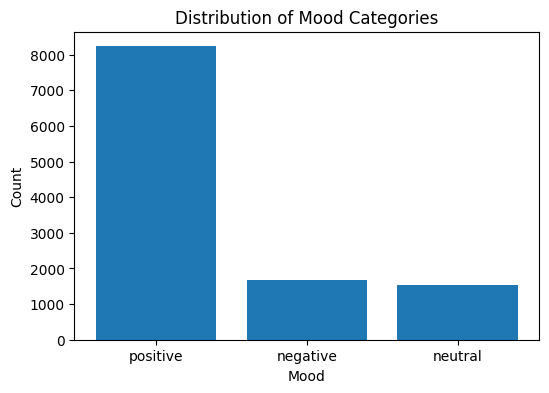

In [75]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.bar(mood_counts.index,mood_counts.values)
plt.xlabel("Mood")
plt.ylabel("Count")
plt.title("Distribution of Mood Categories")

In [76]:
mood_grouped = df.groupby(['topic', 'mood']).size().unstack()


Text(0.5, 1.0, 'Mood Distribution Grouped by Category')

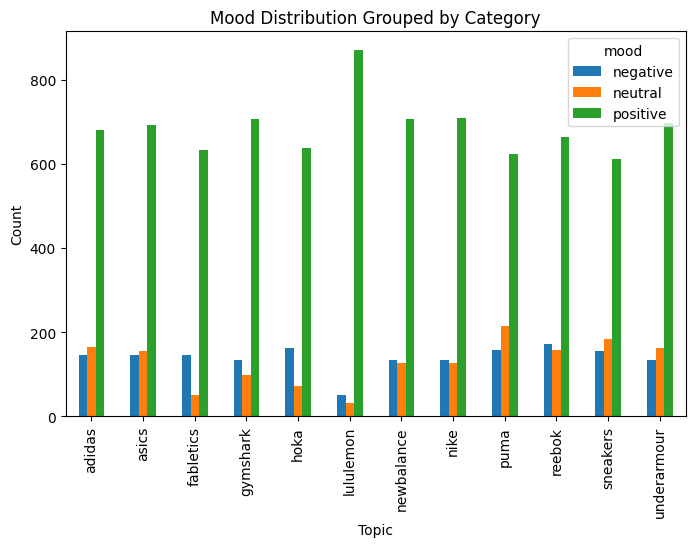

In [79]:
mood_grouped.plot(kind='bar', figsize=(8, 5))
# Customizing the plot
plt.xlabel("Topic")
plt.ylabel("Count")
plt.title("Mood Distribution Grouped by Category")

# K-Means Clustering

In [14]:
import re
import logging
import numpy as np
import pandas as pd
import multiprocessing

from re import sub
from time import time 
from unidecode import unidecode
from gensim.models import Word2Vec
from collections import defaultdict
from gensim.models import KeyedVectors
from gensim.test.utils import get_tmpfile
from gensim.models.phrases import Phrases, Phraser

logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [16]:
df['merged']

0        [id, post, google, article, number, start, rem...
1        [taipeiexclusive, bubble, tea, samba, yay, nay...
2        [gazelle, indoor, burgundy, look, good, new, m...
3        [team, adidas, stan, smith, campus, definitely...
4                [concept, kick, x, adidas, aruku, strung]
                               ...                        
11453    [hey, guy, would, like, share, personal, proje...
11454    [new, project, rock, gear, know, pr, dropped, ...
11455    [men, compression, shortsleggings, pocket, opt...
11456    [name, bag, found, model, wearing, men, ua, un...
11457    [well, sport, mask, fit, need, advice, girlfri...
Name: merged, Length: 11458, dtype: object

In [17]:
sent = [row for row in df.merged]
phrases = Phrases(sent, min_count=1, progress_per=50000)
bigram = Phraser(phrases)
sentences = bigram[sent]
sentences[1]

INFO - 16:24:08: collecting all words and their counts
INFO - 16:24:08: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 16:24:09: collected 229379 token types (unigram + bigrams) from a corpus of 381503 words and 11458 sentences
INFO - 16:24:09: merged Phrases<229379 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
INFO - 16:24:09: Phrases lifecycle event {'msg': 'built Phrases<229379 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.68s', 'datetime': '2025-02-17T16:24:09.105621', 'gensim': '4.1.2', 'python': '3.9.12 (main, Apr  5 2022, 01:53:17) \n[Clang 12.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
INFO - 16:24:09: exporting phrases from Phrases<229379 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
INFO - 16:24:09: FrozenPhrases lifecycle event {'msg': 'exported FrozenPhrases<19001 phrases, min_count=1, threshold=10.0> from Phrases<229379 vocab, min_count=1, threshold=10.0, max_vocab_size=4000

['taipeiexclusive',
 'bubble',
 'tea',
 'samba',
 'yay_nay',
 'thats',
 'pretty',
 'awesome']

In [18]:
w2v_model = Word2Vec(min_count=3,
                     window=4,
                     vector_size=300,
                     sample=1e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=multiprocessing.cpu_count()-1)

start = time()

w2v_model.build_vocab(sentences, progress_per=50000)

print('Time to build vocab: {} mins'.format(round((time() - start) / 60, 2)))

INFO - 16:24:33: Word2Vec lifecycle event {'params': 'Word2Vec(vocab=0, vector_size=300, alpha=0.03)', 'datetime': '2025-02-17T16:24:33.070761', 'gensim': '4.1.2', 'python': '3.9.12 (main, Apr  5 2022, 01:53:17) \n[Clang 12.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
INFO - 16:24:33: collecting all words and their counts
INFO - 16:24:33: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 16:24:33: collected 31962 word types from a corpus of 313698 raw words and 11458 sentences
INFO - 16:24:33: Creating a fresh vocabulary
INFO - 16:24:33: Word2Vec lifecycle event {'msg': 'effective_min_count=3 retains 10853 unique words (33.95594768787936%% of original 31962, drops 21109)', 'datetime': '2025-02-17T16:24:33.642637', 'gensim': '4.1.2', 'python': '3.9.12 (main, Apr  5 2022, 01:53:17) \n[Clang 12.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'prepare_vocab'}
INFO - 16:24:33: Word2Vec lifecycle event {'msg': 'effective_min_co

Time to build vocab: 0.01 mins


In [19]:
start = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - start) / 60, 2)))

w2v_model.init_sims(replace=True)

INFO - 16:24:54: Word2Vec lifecycle event {'msg': 'training model with 7 workers on 10853 vocabulary and 300 features, using sg=0 hs=0 sample=1e-05 negative=20 window=4 shrink_windows=True', 'datetime': '2025-02-17T16:24:54.924085', 'gensim': '4.1.2', 'python': '3.9.12 (main, Apr  5 2022, 01:53:17) \n[Clang 12.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'train'}
INFO - 16:24:55: worker thread finished; awaiting finish of 6 more threads
INFO - 16:24:55: worker thread finished; awaiting finish of 5 more threads
INFO - 16:24:55: worker thread finished; awaiting finish of 4 more threads
INFO - 16:24:55: worker thread finished; awaiting finish of 3 more threads
INFO - 16:24:55: worker thread finished; awaiting finish of 2 more threads
INFO - 16:24:55: worker thread finished; awaiting finish of 1 more threads
INFO - 16:24:55: worker thread finished; awaiting finish of 0 more threads
INFO - 16:24:55: EPOCH - 1 : training on 313698 raw words (81402 effective words) took 0.7s,

Time to train the model: 0.26 mins


In [20]:
w2v_model.save("word2vec.model")

INFO - 16:25:18: Word2Vec lifecycle event {'fname_or_handle': 'word2vec.model', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2025-02-17T16:25:18.505247', 'gensim': '4.1.2', 'python': '3.9.12 (main, Apr  5 2022, 01:53:17) \n[Clang 12.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'saving'}
INFO - 16:25:18: not storing attribute cum_table
INFO - 16:25:18: saved word2vec.model


In [21]:
from gensim.models import Word2Vec
from sklearn.cluster import KMeans

In [24]:
word_vectors = Word2Vec.load("word2vec.model").wv

INFO - 16:26:42: loading Word2Vec object from word2vec.model
INFO - 16:26:42: loading wv recursively from word2vec.model.wv.* with mmap=None
INFO - 16:26:42: setting ignored attribute cum_table to None
INFO - 16:26:43: Word2Vec lifecycle event {'fname': 'word2vec.model', 'datetime': '2025-02-17T16:26:43.076379', 'gensim': '4.1.2', 'python': '3.9.12 (main, Apr  5 2022, 01:53:17) \n[Clang 12.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'loaded'}


In [30]:
model = KMeans(n_clusters=3, max_iter=1000, random_state=True, n_init=50).fit(X=word_vectors.vectors.astype('double'))

AttributeError: 'NoneType' object has no attribute 'split'

In [29]:
word_vectors.similar_by_vector(model.cluster_centers_[1], topn=10, restrict_vocab=None)

In [27]:
positive_cluster_index = 1
positive_cluster_center = model.cluster_centers_[positive_cluster_index]
negative_cluster_center = model.cluster_centers_[1-positive_cluster_index]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 1.9 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 24.3.1
    Uninstalling pip-24.3.1:
      Successfully uninstalled pip-24.3.1


In [ ]:
words = pd.DataFrame(word_vectors.index_to_key)
words.columns = ['words']
words['vectors'] = words.words.apply(lambda x: word_vectors[f'{x}'])
words['cluster'] = words.vectors.apply(lambda x: model.predict([np.array(x)]))
words.cluster = words.cluster.apply(lambda x: x[0])

In [ ]:
words['cluster_value'] = [1 if i==positive_cluster_index else -1 for i in words.cluster]
words['closeness_score'] = words.apply(lambda x: 1/(model.transform([x.vectors]).min()), axis=1)
words['sentiment_coeff'] = words.closeness_score * words.cluster_value